### <span style='color:lightblue'> Importação dos dados e bibliotecas</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, normalized_mutual_info_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from feature_engine.encoding import RareLabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

In [3]:
base = pd.read_csv("shopping.csv")

### <span style='color:lightblue'> Pré-processamento </span>

#### Buscando Outliers

In [4]:
# Definir o limite para rareza (exemplo: categorias que aparecem em menos de 1% dos casos)
rare_encoder = RareLabelEncoder(tol=0.01, replace_with='Outros')

# Ajustar e transformar todas as colunas categóricas
base = rare_encoder.fit_transform(base)

c:\Users\ander\anaconda3\envs\py38\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\ander\anaconda3\envs\py38\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Category is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\ander\anaconda3\envs\py38\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Size is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\ander\anaconda3\envs\py38\lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable Season is less than that indic

In [5]:
# Verificar as colunas categóricas
columns = base.select_dtypes(include=['object']).columns

# Filtrar as linhas que possuem "Outros" em qualquer coluna categórica
outros_rows = base[base[columns].apply(lambda x: x.str.contains('Outros')).any(axis=1)]

# Exibir as linhas
print(outros_rows)

Empty DataFrame
Columns: [Customer ID, Age, Gender, Item Purchased, Category, Purchase Amount (USD), Location, Size, Color, Season, Review Rating, Subscription Status, Shipping Type, Discount Applied, Promo Code Used, Previous Purchases, Payment Method, Frequency of Purchases]
Index: []


#### Entendendo o dataset

In [6]:
base.describe()

Customer ID          Age  Purchase Amount (USD)  Review Rating  \
count  3900.000000  3900.000000            3900.000000    3900.000000   
mean   1950.500000    44.068462              59.764359       3.749949   
std    1125.977353    15.207589              23.685392       0.716223   
min       1.000000    18.000000              20.000000       2.500000   
25%     975.750000    31.000000              39.000000       3.100000   
50%    1950.500000    44.000000              60.000000       3.700000   
75%    2925.250000    57.000000              81.000000       4.400000   
max    3900.000000    70.000000             100.000000       5.000000   

       Previous Purchases  
count         3900.000000  
mean            25.351538  
std             14.447125  
min              1.000000  
25%             13.000000  
50%             25.000000  
75%             38.000000  
max             50.000000

In [7]:
base.isnull().sum()

Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
dtype: int64

In [8]:
base = base.drop(columns=['Customer ID'])
base.describe()

Age  Purchase Amount (USD)  Review Rating  Previous Purchases
count  3900.000000            3900.000000    3900.000000         3900.000000
mean     44.068462              59.764359       3.749949           25.351538
std      15.207589              23.685392       0.716223           14.447125
min      18.000000              20.000000       2.500000            1.000000
25%      31.000000              39.000000       3.100000           13.000000
50%      44.000000              60.000000       3.700000           25.000000
75%      57.000000              81.000000       4.400000           38.000000
max      70.000000             100.000000       5.000000           50.000000

In [9]:
#Label encoding
label = LabelEncoder()
base['Frequency of Purchases'] = label.fit_transform(base['Frequency of Purchases'])

#One hot encoding
base = pd.get_dummies(base, columns=['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method'])

In [10]:
base

Age  Purchase Amount (USD)  Review Rating  Previous Purchases  \
0      55                     53            3.1                  14   
1      19                     64            3.1                   2   
2      50                     73            3.1                  23   
3      21                     90            3.5                  49   
4      45                     49            2.7                  31   
...   ...                    ...            ...                 ...   
3895   40                     28            4.2                  32   
3896   52                     49            4.5                  41   
3897   46                     33            2.9                  24   
3898   44                     77            3.8                  24   
3899   52                     81            3.1                  33   

      Frequency of Purchases  Gender_Female  Gender_Male  \
0                          3              0            1   
1                          3              0            1   
2                          6              0            1   
3                          6              0            1   
4                          0              0            1   
...                      ...            ...          ...   
3895                       6              1            0   
3896                       1              1            0   
3897                       5              1            0   
3898                       6              1            0   
3899                       5              1            0   

      Item Purchased_Backpack  Item Purchased_Belt  Item Purchased_Blouse  \
0                           0                    0                      1   
1                           0                    0                      0   
2                           0                    0                      0   
3                           0                    0                      0   
4                           0                    0                      1   
...                       ...                  ...                    ...   
3895                        0                    0                      0   
3896                        1                    0                      0   
3897                        0                    1                      0   
3898                        0                    0                      0   
3899                        0                    0                      0   

      ...  Discount Applied_No  Discount Applied_Yes  Promo Code Used_No  \
0     ...                    0                     1                   0   
1     ...                    0                     1                   0   
2     ...                    0                     1                   0   
3     ...                    0                     1                   0   
4     ...                    0                     1                   0   
...   ...                  ...                   ...                 ...   
3895  ...                    1                     0                   1   
3896  ...                    1                     0                   1   
3897  ...                    1                     0                   1   
3898  ...                    1                     0                   1   
3899  ...                    1                     0                   1   

      Promo Code Used_Yes  Payment Method_Bank Transfer  Payment Method_Cash  \
0                       1                             0                    0   
1                       1                             0                    1   
2                       1                             0                    0   
3                       1                             0                    0   
4                       1                             0                    0   
...                   ...                           ...                  ...   
3895                    0         

#### Escalonamento

In [11]:
numerical_columns = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Frequency of Purchases']
categorical_columns = base.columns.difference(numerical_columns)
scaler = StandardScaler()
base[numerical_columns] = scaler.fit_transform(base[numerical_columns])

In [12]:
base

Age  Purchase Amount (USD)  Review Rating  Previous Purchases  \
0     0.718913              -0.285629      -0.907584           -0.785831   
1    -1.648629               0.178852      -0.907584           -1.616552   
2     0.390088               0.558882      -0.907584           -0.162789   
3    -1.517099               1.276716      -0.349027            1.637107   
4     0.061263              -0.454531      -1.466141            0.391025   
...        ...                    ...            ...                 ...   
3895 -0.267563              -1.341267       0.628448            0.460252   
3896  0.521618              -0.454531       1.047366            1.083293   
3897  0.127028              -1.130139      -1.186862           -0.093563   
3898 -0.004502               0.727784       0.069891           -0.093563   
3899  0.521618               0.896686      -0.907584            0.529479   

      Frequency of Purchases  Gender_Female  Gender_Male  \
0                   0.012575              0            1   
1                   0.012575              0            1   
2                   1.513849              0            1   
3                   1.513849              0            1   
4                  -1.488699              0            1   
...                      ...            ...          ...   
3895                1.513849              1            0   
3896               -0.988274              1            0   
3897                1.013424              1            0   
3898                1.513849              1            0   
3899                1.013424              1            0   

      Item Purchased_Backpack  Item Purchased_Belt  Item Purchased_Blouse  \
0                           0                    0                      1   
1                           0                    0                      0   
2                           0                    0                      0   
3                           0                    0                      0   
4                           0                    0                      1   
...                       ...                  ...                    ...   
3895                        0                    0                      0   
3896                        1                    0                      0   
3897                        0                    1                      0   
3898                        0                    0                      0   
3899                        0                    0                      0   

      ...  Discount Applied_No  Discount Applied_Yes  Promo Code Used_No  \
0     ...                    0                     1                   0   
1     ...                    0                     1                   0   
2     ...                    0                     1                   0   
3     ...                    0                     1                   0   
4     ...                    0                     1                   0   
...   ...                  ...                   ...                 ...   
3895  ...                    1                     0                   1   
3896  ...                    1                     0                   1   
3897  ...                    1                     0                   1   
3898  ...                    1                     0                   1   
3899  ...                    1                     0                   1   

      Promo Code Used_Yes  Payment Method_Bank Transfer  Payment Method_Cash  \
0                       1                             0                    0   
1                       1                             0                    1   
2                       1                             0                    0   
3                       1                             0                    0   
4                       1                             0                    0   
...                   ...                           ...    

### <span style='color:#C877E0'> K-Means </span>

#### Técnica do cotovelo (Elbow Method)

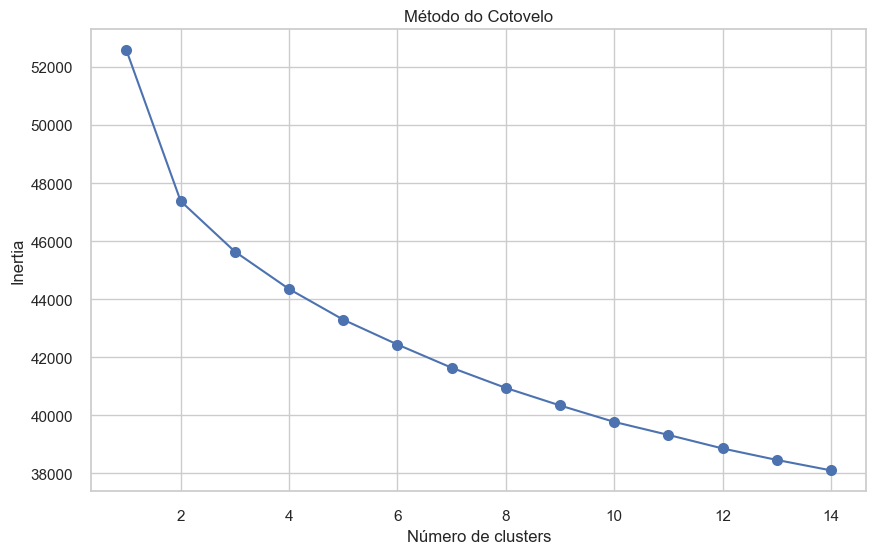

In [86]:
inertias = [] #soma dos quadrados das distâncias internas
K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(base)
    inertias.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bo-', markersize=8)
plt.title("Método do Cotovelo")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia")
plt.show()

#### Fit

In [35]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(base)

c:\Users\ander\anaconda3\envs\py38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\ander\anaconda3\envs\py38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\ander\anaconda3\envs\py38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


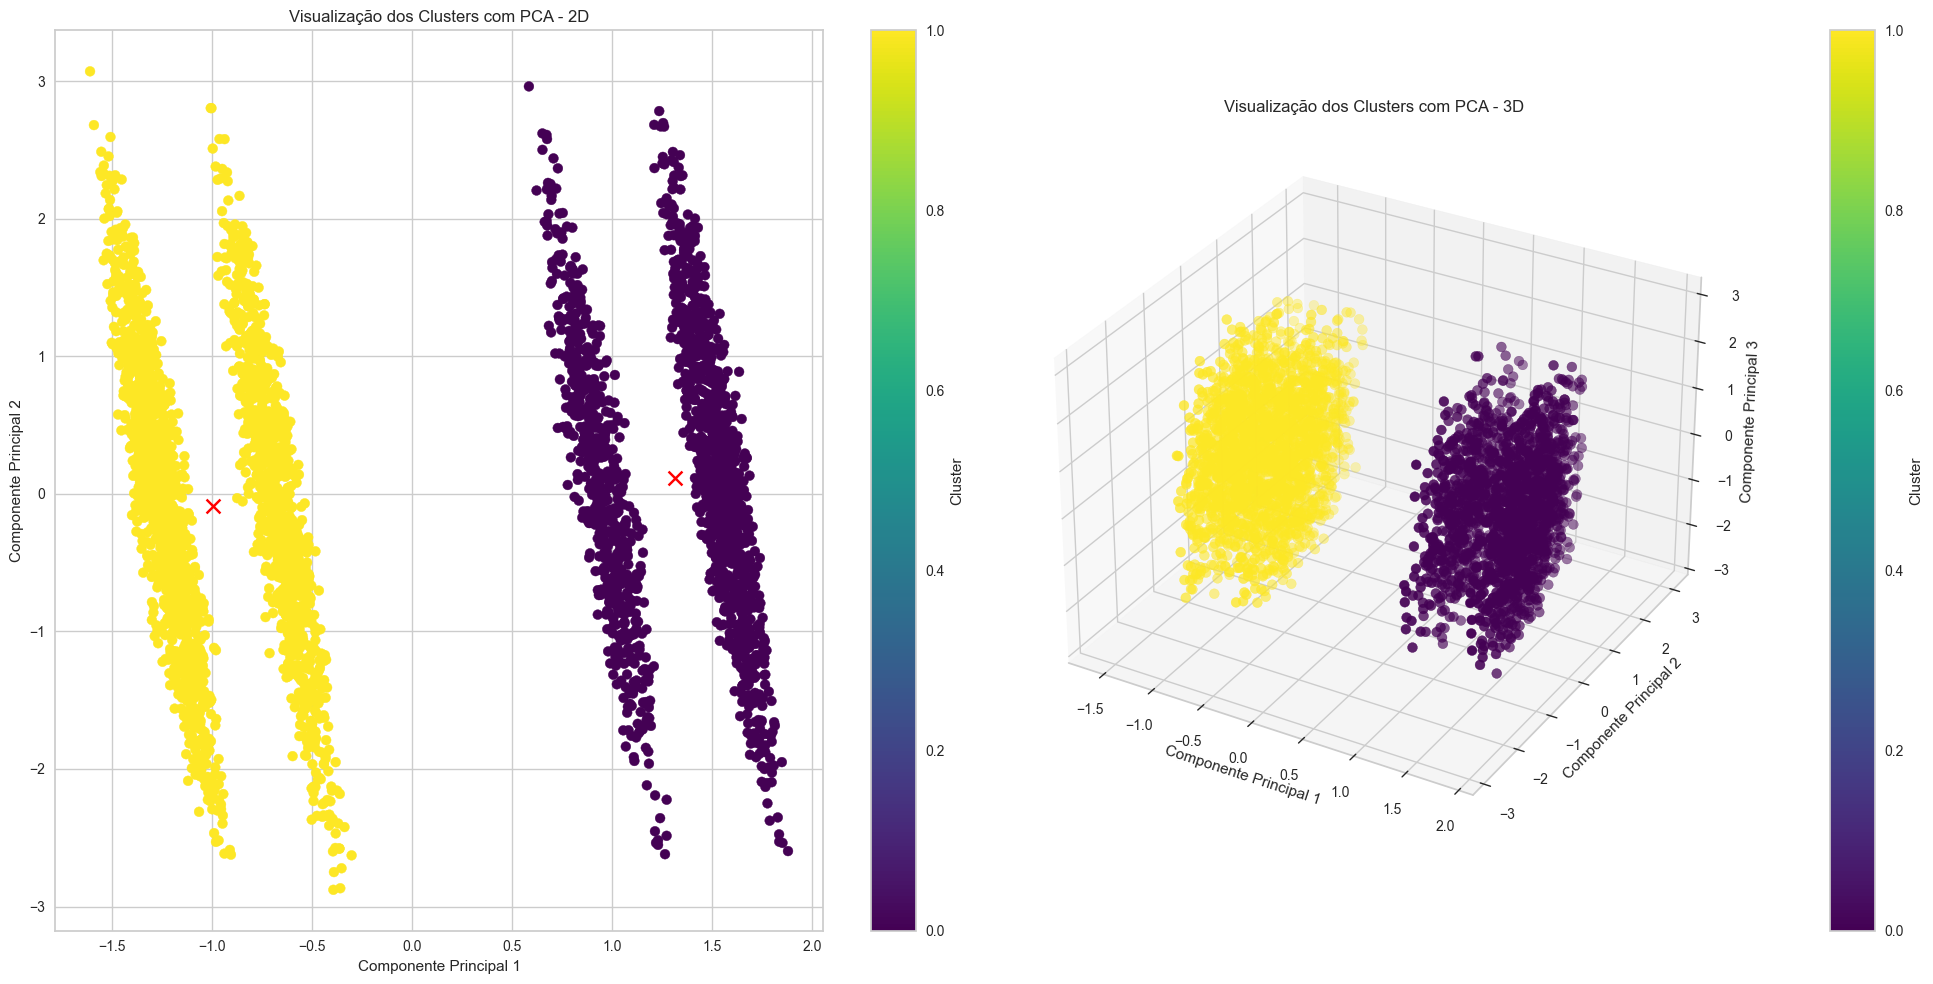

In [14]:
#USANDO O PCA
# Reduzir a dimensionalidade para 2 componentes principais
pca = PCA(n_components=2)
base_pca = pca.fit_transform(base)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# Reduzir a dimensionalidade para 3 componentes principais
pca_3d = PCA(n_components=3)
base_pca_3d = pca_3d.fit_transform(base)
centroids_pca_3d = pca_3d.transform(centroids)


# Criar uma figura com 2 subplots lado a lado
fig = plt.figure(figsize=(20, 10))

# Subplot 1: Gráfico 2D
ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(base_pca[:, 0], base_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=50)
ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=100, label='Centróides')
ax1.set_title("Visualização dos Clusters com PCA - 2D")
ax1.set_xlabel("Componente Principal 1")
ax1.set_ylabel("Componente Principal 2")
cbar1 = plt.colorbar(scatter_2d, ax=ax1)
cbar1.set_label('Cluster')

# Subplot 2: Gráfico 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(base_pca_3d[:, 0], base_pca_3d[:, 1], base_pca_3d[:, 2], c=kmeans_labels, cmap='viridis', marker='o', s=50)
ax2.set_title("Visualização dos Clusters com PCA - 3D")
ax2.set_xlabel("Componente Principal 1")
ax2.set_ylabel("Componente Principal 2")
ax2.set_zlabel("Componente Principal 3")

# Adicionar a barra de cores para o gráfico 3D
cbar2 = plt.colorbar(scatter_3d, ax=ax2, pad=0.1)
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()

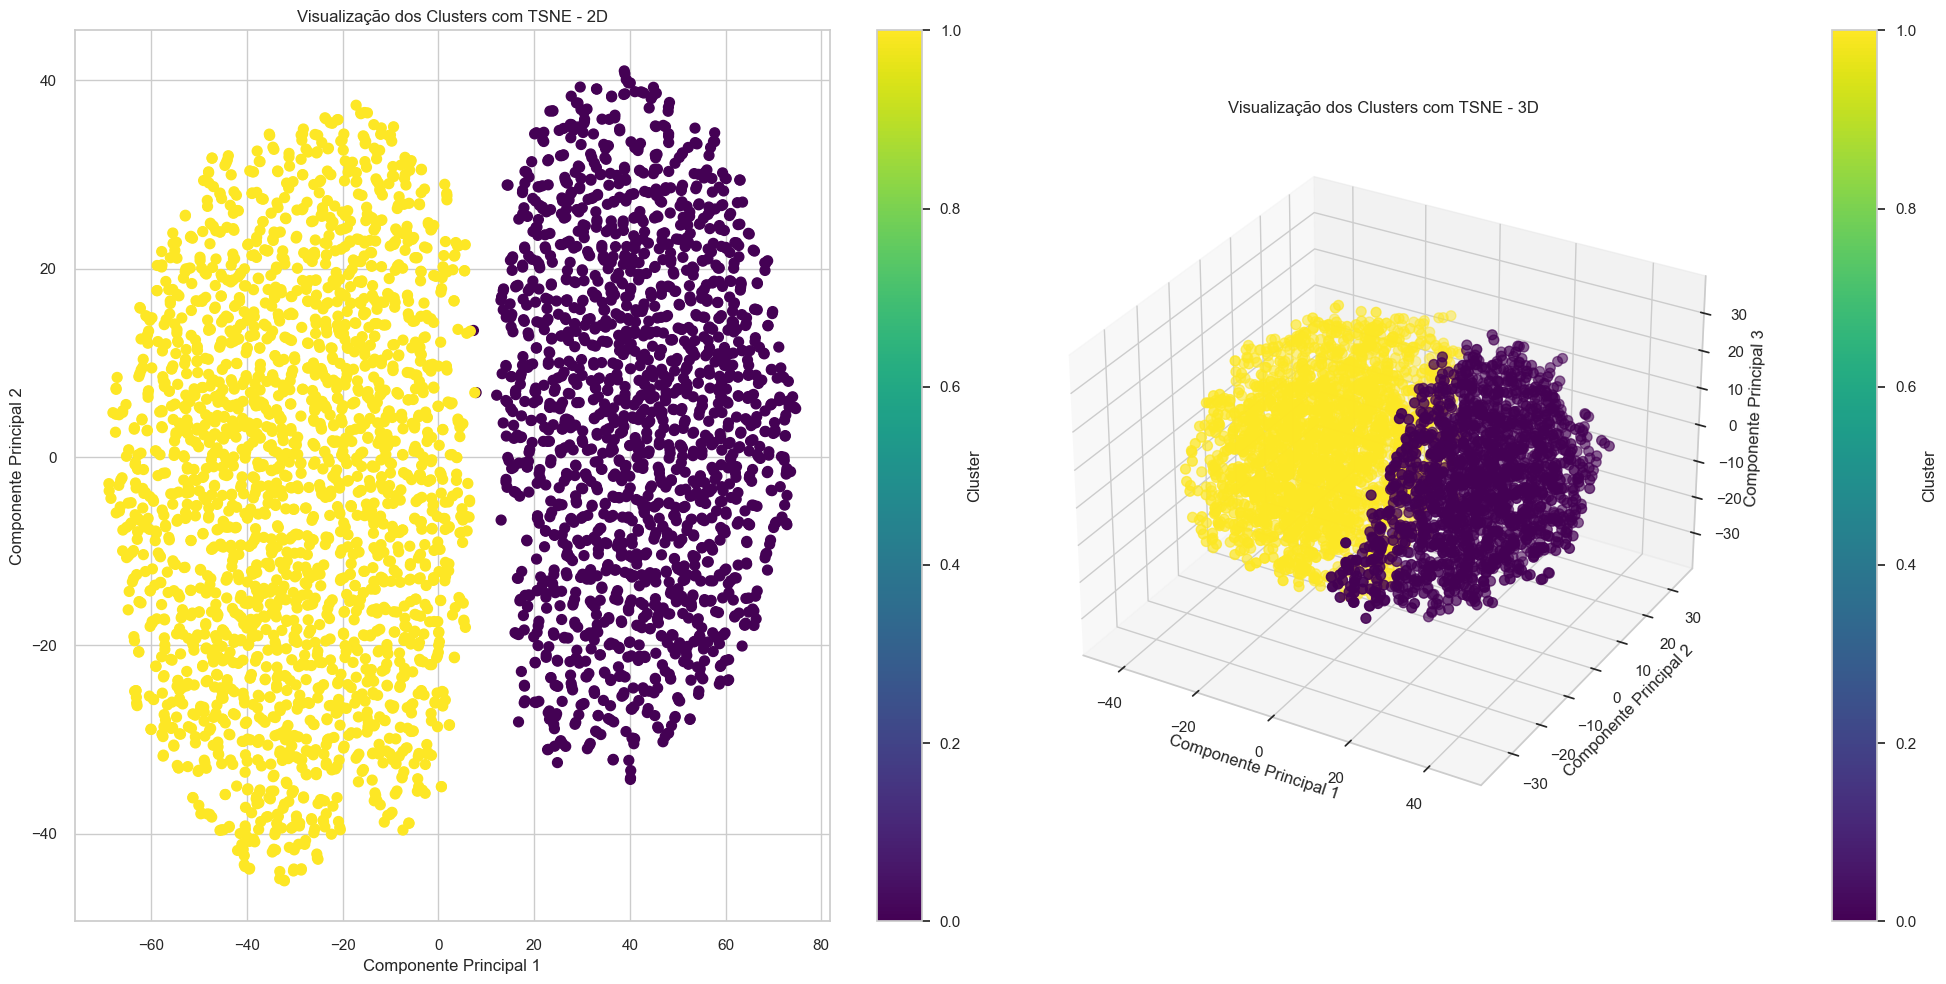

In [105]:
#USANDO O TSNE
# Reduzir a dimensionalidade para 2 componentes principais
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
base_tsne = tsne.fit_transform(base)

# Reduzir a dimensionalidade para 3 componentes principais
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
base_tsne_3d = tsne_3d.fit_transform(base)

# Criar uma figura com 2 subplots lado a lado
fig = plt.figure(figsize=(20, 10))

# Subplot 1: Gráfico 2D
ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(base_tsne[:, 0], base_tsne[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=50)
ax1.set_title("Visualização dos Clusters com TSNE - 2D")
ax1.set_xlabel("Componente Principal 1")
ax1.set_ylabel("Componente Principal 2")
cbar1 = plt.colorbar(scatter_2d, ax=ax1)
cbar1.set_label('Cluster')

# Subplot 2: Gráfico 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(base_tsne_3d[:, 0], base_tsne_3d[:, 1], base_tsne_3d[:, 2], c=kmeans_labels, cmap='viridis', marker='o', s=50)
ax2.set_title("Visualização dos Clusters com TSNE - 3D")
ax2.set_xlabel("Componente Principal 1")
ax2.set_ylabel("Componente Principal 2")
ax2.set_zlabel("Componente Principal 3")

# Adicionar a barra de cores para o gráfico 3D
cbar2 = plt.colorbar(scatter_3d, ax=ax2, pad=0.1)
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()

c:\Users\ander\anaconda3\envs\py38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


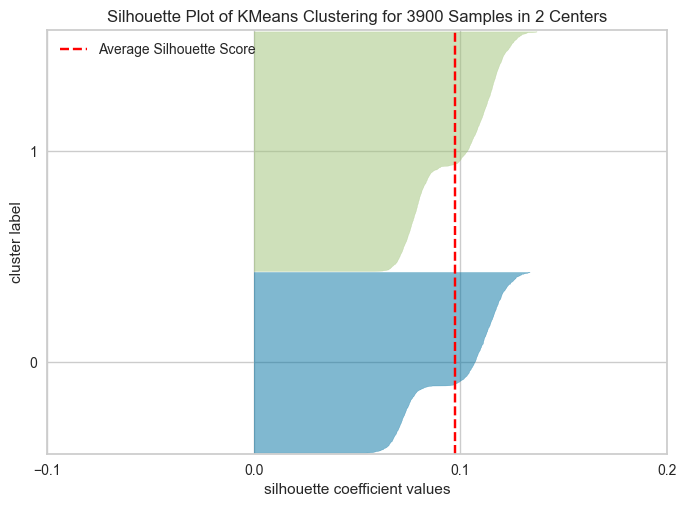

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3900 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(base)       
visualizer.show() 

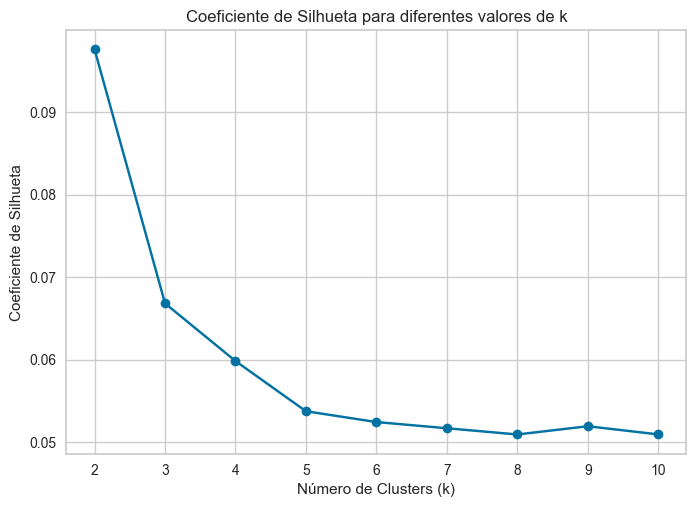

In [17]:
range_n_clusters = list(range(2, 11))

# Listas para armazenar os resultados
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Aplicar o KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(base)
    
    # Calcular o coeficiente de silhueta
    silhouette_avg = silhouette_score(base, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Visualizar os resultados
plt.figure()
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta para diferentes valores de k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhueta')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

### <span style='color:#C877E0'> Clusterização Hierárquica </span>

Text(0, 0.5, 'Distancia')

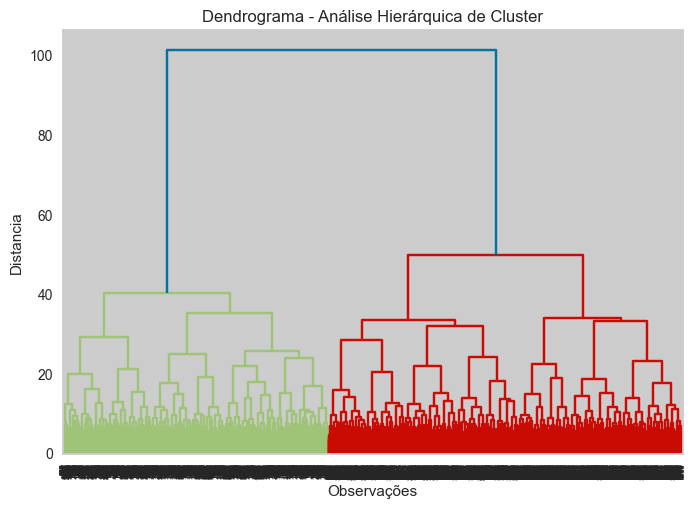

In [15]:
#Análise Hierárquica de Cluster (HCA)
linked = linkage(base, method='ward')
dendrogram(linked)
plt.title('Dendrograma - Análise Hierárquica de Cluster')
plt.xlabel('Observações')
plt.ylabel('Distancia')

In [16]:
# Cortar pelo número de clusters
hierarchical_labels_3 = cut_tree(linked, n_clusters=3)
hierarchical_labels_2 = cut_tree(linked, n_clusters=2)

# O corte no dendrograma substitui o codigo abaixo
hierarchical = AgglomerativeClustering(n_clusters=2)
hierarchical_labels = hierarchical.fit_predict(base)

In [20]:
# Checando se é igual
array_1 = 1 - hierarchical_labels
array_2 = hierarchical_labels_2

array_2_flat = array_2.flatten()

# Verificar a porcentagem de igualdade
igualdade = np.mean(array_1 == array_2_flat)
percentual_igualdade = igualdade * 100

print(f'Porcentagem de igualdade: {percentual_igualdade:.2f}%')

Porcentagem de igualdade: 100.00%


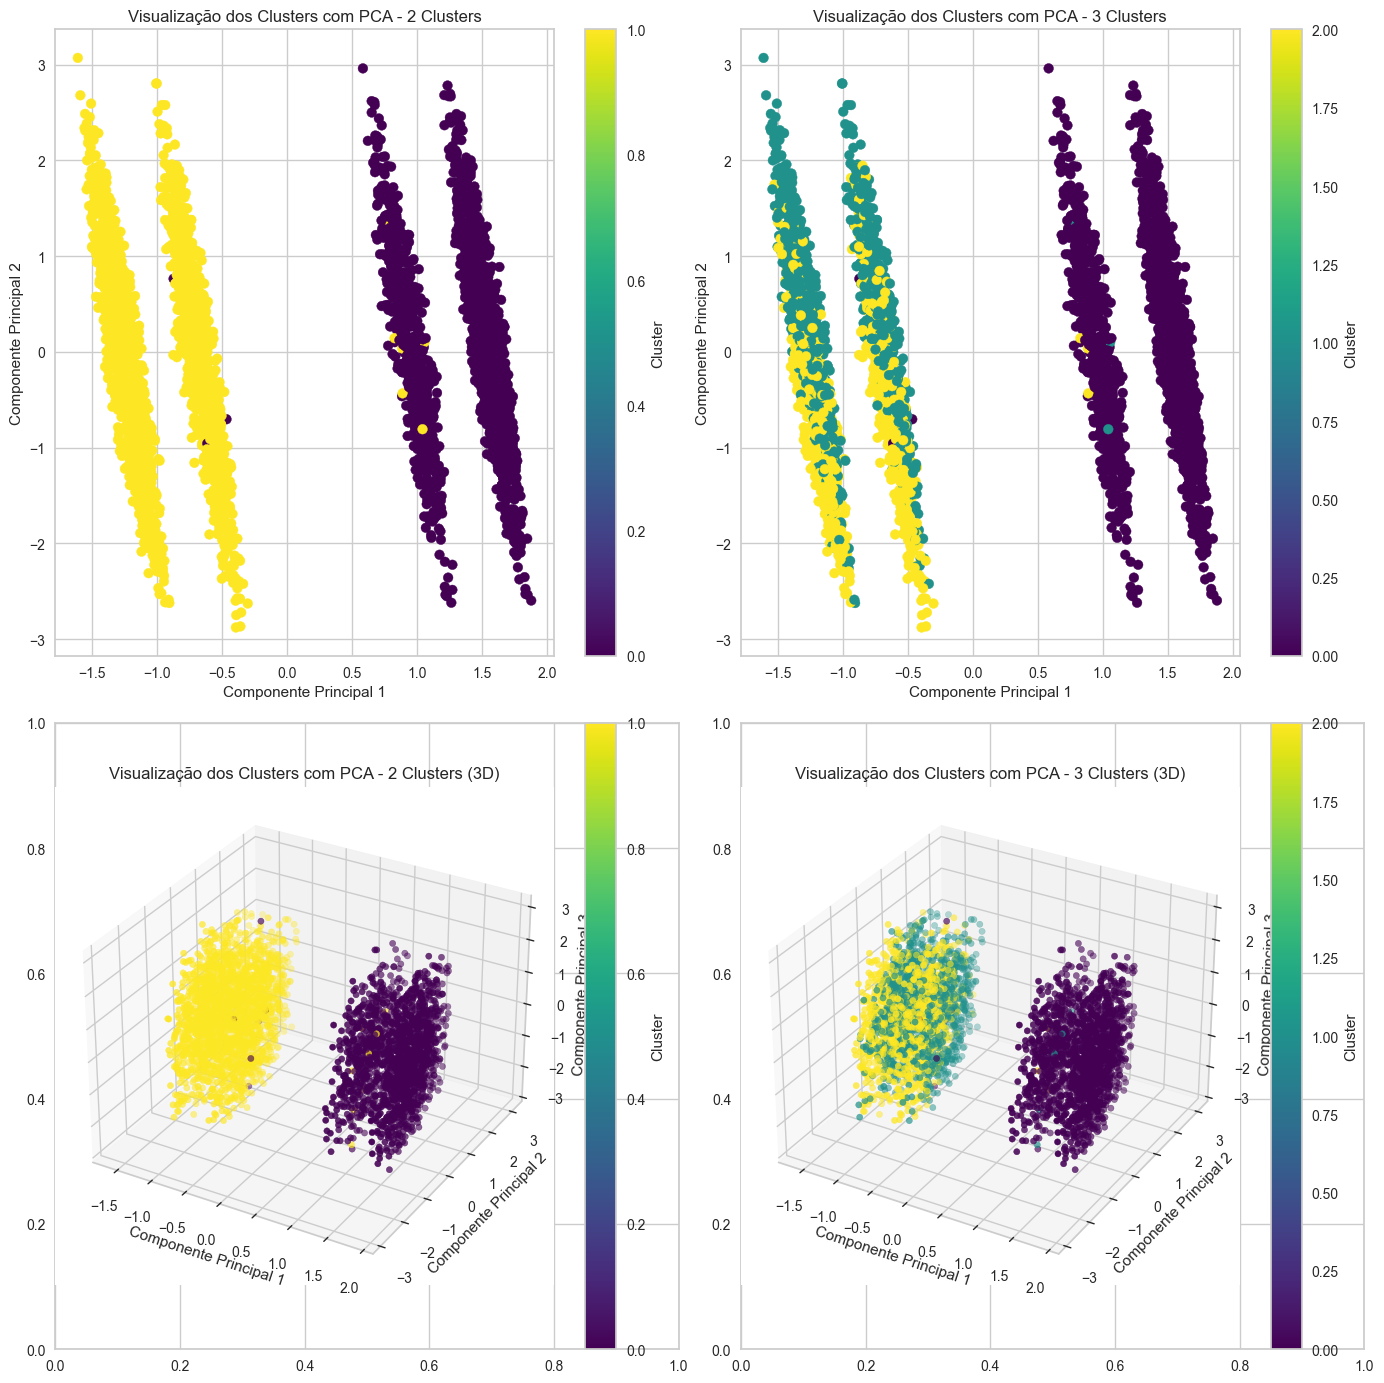

In [21]:
#PCA
#GRAFICOS PARA 2 E 3 CLUSTERS
# Reduzir a dimensionalidade para 2 componentes principais
pca = PCA(n_components=2)
base_pca = pca.fit_transform(base)

# Reduzir a dimensionalidade para 3 componentes principais
pca_3d = PCA(n_components=3)
base_pca_3d = pca_3d.fit_transform(base)

# Criar uma figura com 2 linhas e 2 colunas de subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plotar o primeiro gráfico 2D
sc1 = axs[0, 0].scatter(base_pca[:, 0], base_pca[:, 1], c=hierarchical_labels_2, cmap='viridis', marker='o')
axs[0, 0].set_title("Visualização dos Clusters com PCA - 2 Clusters")
axs[0, 0].set_xlabel("Componente Principal 1")
axs[0, 0].set_ylabel("Componente Principal 2")
fig.colorbar(sc1, ax=axs[0, 0], label='Cluster')

# Plotar o segundo gráfico 2D
sc2 = axs[0, 1].scatter(base_pca[:, 0], base_pca[:, 1], c=hierarchical_labels_3, cmap='viridis', marker='o')
axs[0, 1].set_title("Visualização dos Clusters com PCA - 3 Clusters")
axs[0, 1].set_xlabel("Componente Principal 1")
axs[0, 1].set_ylabel("Componente Principal 2")
fig.colorbar(sc2, ax=axs[0, 1], label='Cluster')

# Plotar o primeiro gráfico 3D
ax3d_1 = fig.add_subplot(2, 2, 3, projection='3d')
scatter_3d_1 = ax3d_1.scatter(base_pca_3d[:, 0], base_pca_3d[:, 1], base_pca_3d[:, 2], c=hierarchical_labels_2, cmap='viridis', marker='o')
ax3d_1.set_title("Visualização dos Clusters com PCA - 2 Clusters (3D)")
ax3d_1.set_xlabel("Componente Principal 1")
ax3d_1.set_ylabel("Componente Principal 2")
ax3d_1.set_zlabel("Componente Principal 3")
fig.colorbar(scatter_3d_1, ax=ax3d_1, label='Cluster')

# Plotar o segundo gráfico 3D
ax3d_2 = fig.add_subplot(2, 2, 4, projection='3d')
scatter_3d_2 = ax3d_2.scatter(base_pca_3d[:, 0], base_pca_3d[:, 1], base_pca_3d[:, 2], c=hierarchical_labels_3, cmap='viridis', marker='o')
ax3d_2.set_title("Visualização dos Clusters com PCA - 3 Clusters (3D)")
ax3d_2.set_xlabel("Componente Principal 1")
ax3d_2.set_ylabel("Componente Principal 2")
ax3d_2.set_zlabel("Componente Principal 3")
fig.colorbar(scatter_3d_2, ax=ax3d_2, label='Cluster')

plt.tight_layout()
plt.show()

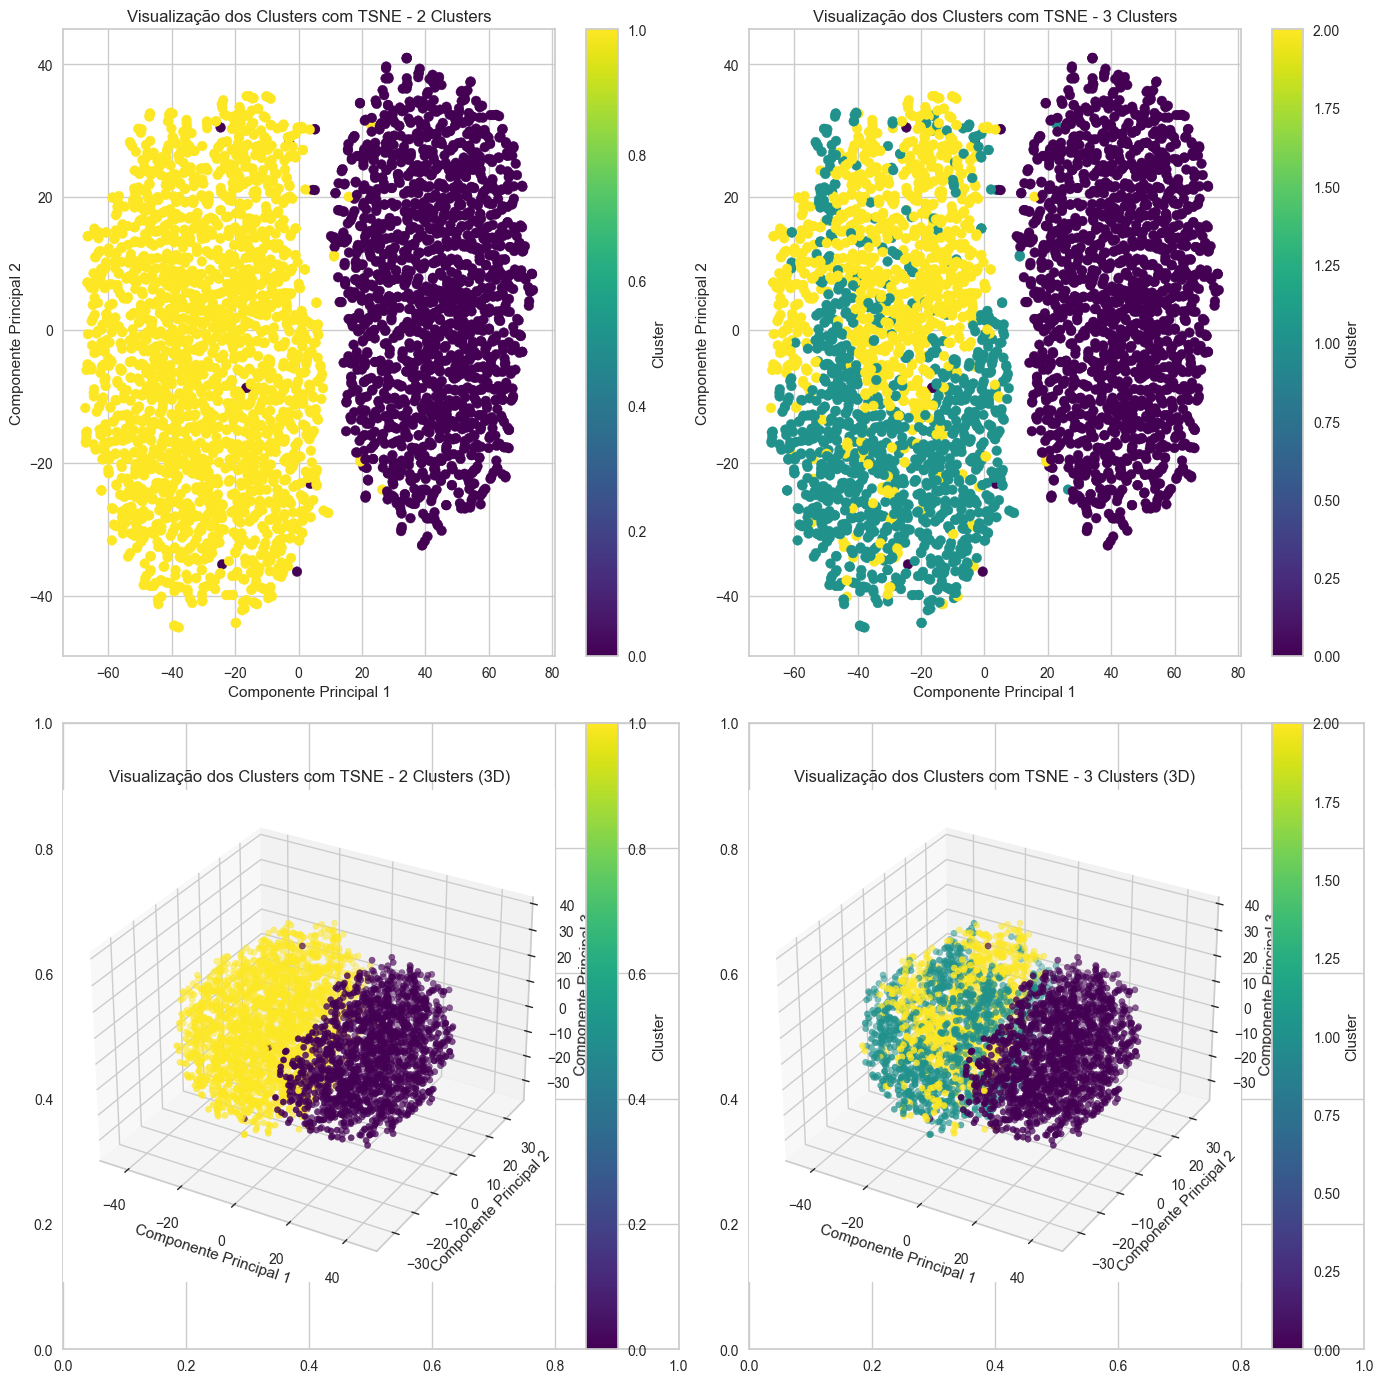

In [22]:
#TSNE
#GRAFICOS PARA 2 E 3 CLUSTERS
# Reduzir a dimensionalidade para 2 componentes principais
tsne = TSNE(n_components=2)
base_tsne = tsne.fit_transform(base)

# Reduzir a dimensionalidade para 3 componentes principais
tsne_3d = TSNE(n_components=3)
base_tsne_3d = tsne_3d.fit_transform(base)

# Criar uma figura com 2 linhas e 2 colunas de subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plotar o primeiro gráfico 2D
sc1 = axs[0, 0].scatter(base_tsne[:, 0], base_tsne[:, 1], c=hierarchical_labels_2, cmap='viridis', marker='o')
axs[0, 0].set_title("Visualização dos Clusters com TSNE - 2 Clusters")
axs[0, 0].set_xlabel("Componente Principal 1")
axs[0, 0].set_ylabel("Componente Principal 2")
fig.colorbar(sc1, ax=axs[0, 0], label='Cluster')

# Plotar o segundo gráfico 2D
sc2 = axs[0, 1].scatter(base_tsne[:, 0], base_tsne[:, 1], c=hierarchical_labels_3, cmap='viridis', marker='o')
axs[0, 1].set_title("Visualização dos Clusters com TSNE - 3 Clusters")
axs[0, 1].set_xlabel("Componente Principal 1")
axs[0, 1].set_ylabel("Componente Principal 2")
fig.colorbar(sc2, ax=axs[0, 1], label='Cluster')

# Plotar o primeiro gráfico 3D
ax3d_1 = fig.add_subplot(2, 2, 3, projection='3d')
scatter_3d_1 = ax3d_1.scatter(base_tsne_3d[:, 0], base_tsne_3d[:, 1], base_tsne_3d[:, 2], c=hierarchical_labels_2, cmap='viridis', marker='o')
ax3d_1.set_title("Visualização dos Clusters com TSNE - 2 Clusters (3D)")
ax3d_1.set_xlabel("Componente Principal 1")
ax3d_1.set_ylabel("Componente Principal 2")
ax3d_1.set_zlabel("Componente Principal 3")
fig.colorbar(scatter_3d_1, ax=ax3d_1, label='Cluster')

# Plotar o segundo gráfico 3D
ax3d_2 = fig.add_subplot(2, 2, 4, projection='3d')
scatter_3d_2 = ax3d_2.scatter(base_tsne_3d[:, 0], base_tsne_3d[:, 1], base_tsne_3d[:, 2], c=hierarchical_labels_3, cmap='viridis', marker='o')
ax3d_2.set_title("Visualização dos Clusters com TSNE - 3 Clusters (3D)")
ax3d_2.set_xlabel("Componente Principal 1")
ax3d_2.set_ylabel("Componente Principal 2")
ax3d_2.set_zlabel("Componente Principal 3")
fig.colorbar(scatter_3d_2, ax=ax3d_2, label='Cluster')

plt.tight_layout()
plt.show()

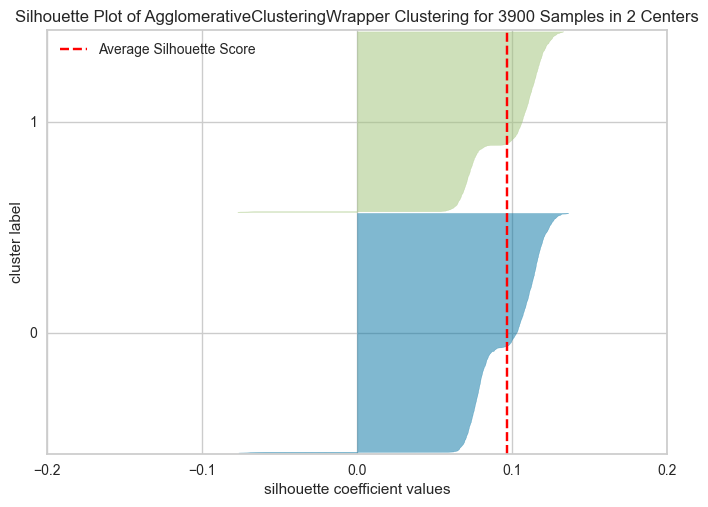

<Axes: title={'center': 'Silhouette Plot of AgglomerativeClusteringWrapper Clustering for 3900 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [23]:

class AgglomerativeClusteringWrapper(AgglomerativeClustering):
    def predict(self, data):
        return self.labels_.astype(int)

clusters = AgglomerativeClusteringWrapper(n_clusters=2, linkage='ward')
wrapper_labels = clusters.fit_predict(base)

visualizer = SilhouetteVisualizer(clusters, colors='yellowbrick')
visualizer.fit(base)
visualizer.show()

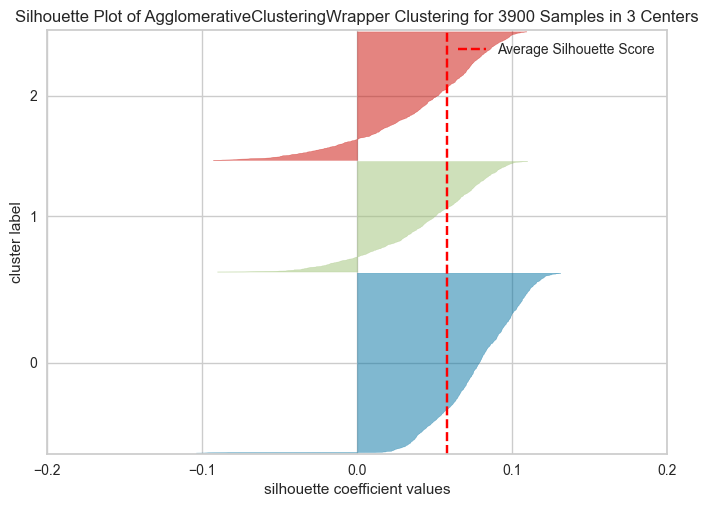

<Axes: title={'center': 'Silhouette Plot of AgglomerativeClusteringWrapper Clustering for 3900 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:

class AgglomerativeClusteringWrapper(AgglomerativeClustering):
    def predict(self, data):
        return self.labels_.astype(int)

clusters3 = AgglomerativeClusteringWrapper(n_clusters=3, linkage='ward')
wrapper_labels = clusters3.fit_predict(base)

visualizer = SilhouetteVisualizer(clusters3, colors='yellowbrick')
visualizer.fit(base)
visualizer.show()

### <span style='color:#C877E0'> DBSCAN </span>

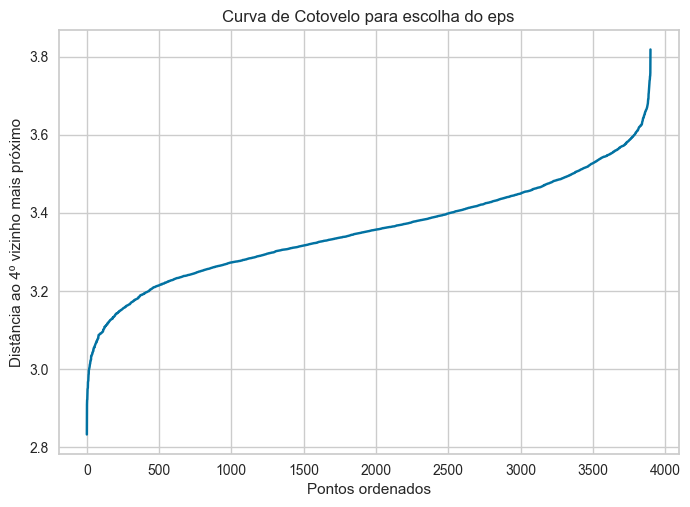

In [24]:
neigh = NearestNeighbors(n_neighbors=1000)
nbrs = neigh.fit(base)
distances, indices = nbrs.kneighbors(base)

# Ordenar as distâncias e plotar
distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.title('Curva de Cotovelo para escolha do eps')
plt.xlabel('Pontos ordenados')
plt.ylabel('Distância ao 4º vizinho mais próximo')
plt.show()

In [25]:
eps_values = np.linspace(3.5, 4.5, 20)
for eps in eps_values:

    dbscan = DBSCAN(eps=eps, min_samples=100)
    labels = dbscan.fit_predict(base)
    #imprime a quantidade de clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'Número de clusters: {n_clusters}, eps: {eps}')

Número de clusters: 0, eps: 3.5
Número de clusters: 0, eps: 3.5526315789473686
Número de clusters: 0, eps: 3.6052631578947367
Número de clusters: 1, eps: 3.6578947368421053
Número de clusters: 1, eps: 3.7105263157894735
Número de clusters: 4, eps: 3.763157894736842
Número de clusters: 1, eps: 3.8157894736842106
Número de clusters: 1, eps: 3.8684210526315788
Número de clusters: 1, eps: 3.9210526315789473
Número de clusters: 1, eps: 3.973684210526316
Número de clusters: 1, eps: 4.026315789473684
Número de clusters: 1, eps: 4.078947368421053
Número de clusters: 1, eps: 4.131578947368421
Número de clusters: 1, eps: 4.184210526315789
Número de clusters: 1, eps: 4.2368421052631575
Número de clusters: 1, eps: 4.2894736842105265
Número de clusters: 1, eps: 4.342105263157895
Número de clusters: 1, eps: 4.394736842105263
Número de clusters: 1, eps: 4.447368421052632
Número de clusters: 1, eps: 4.5


In [36]:
dbscan = DBSCAN(eps=3.7894736842105265, min_samples=100)
dbscan_labels = dbscan.fit_predict(base)

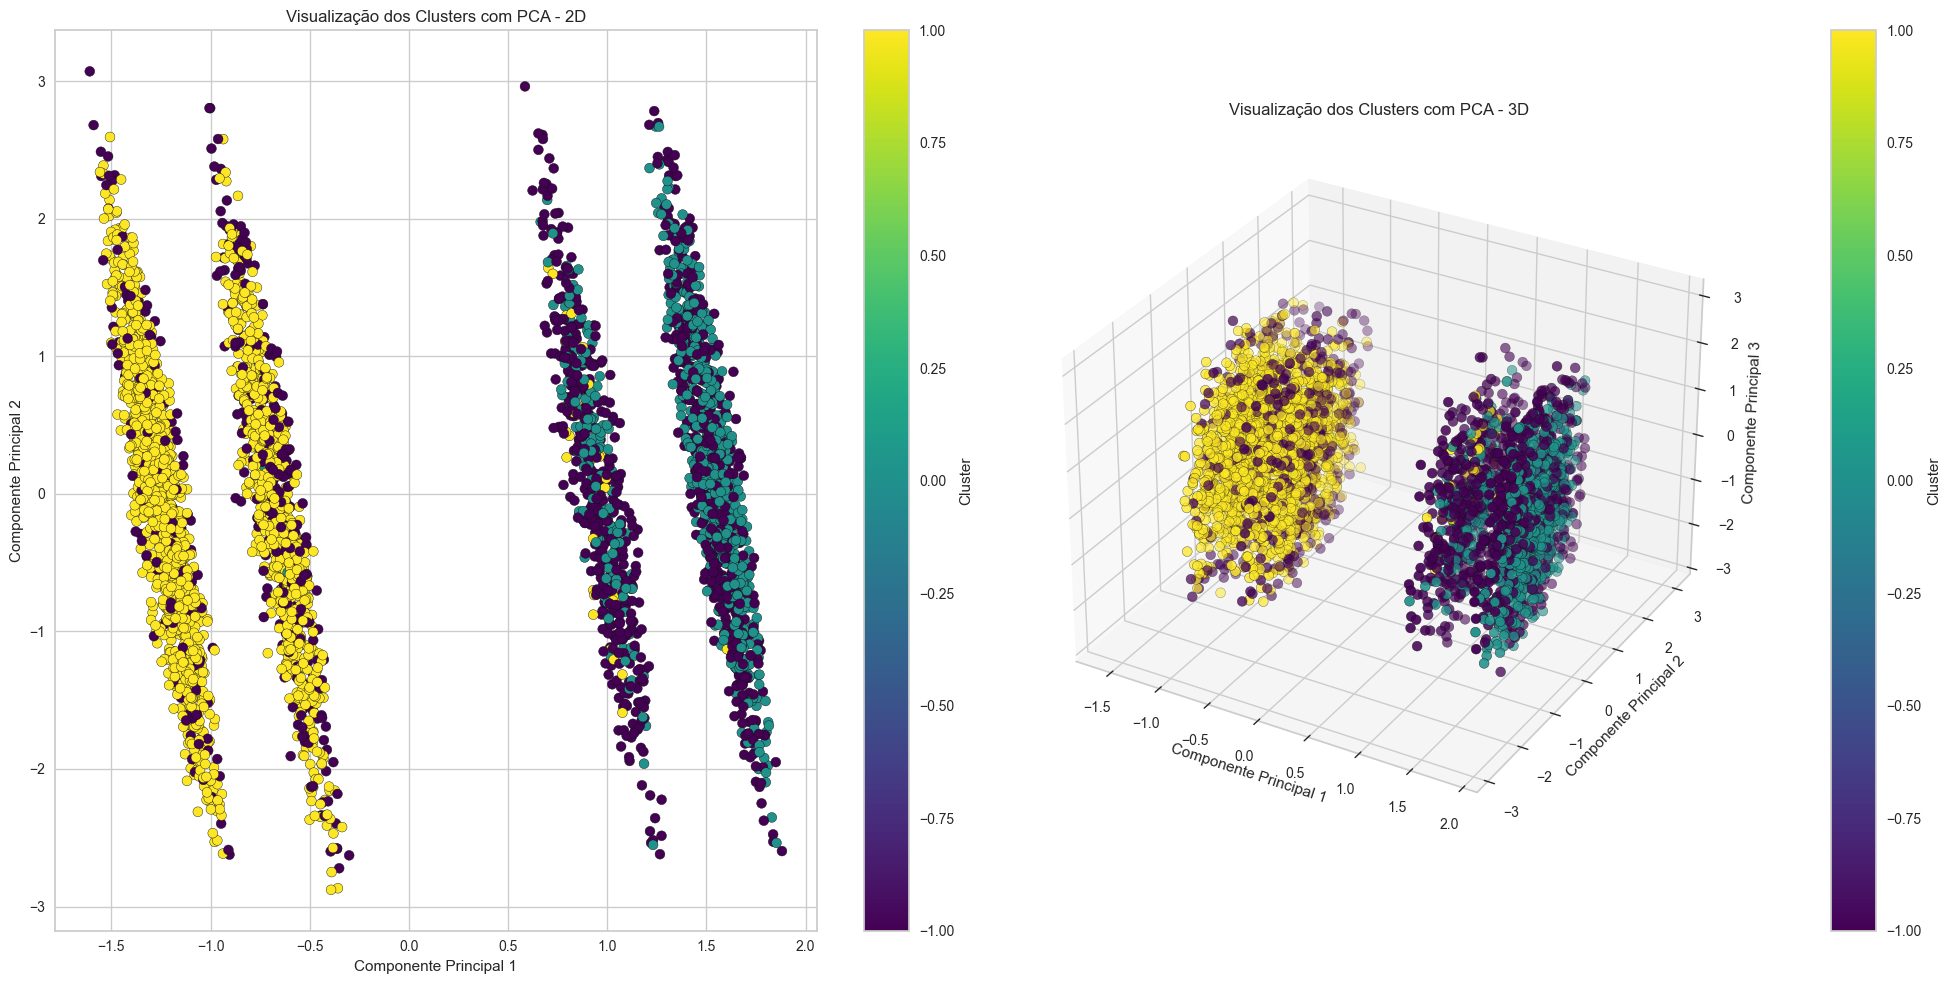

In [27]:
#PCA
# Reduzir a dimensionalidade para 2 componentes principais
pca = PCA(n_components=2)
base_pca = pca.fit_transform(base)

# Reduzir a dimensionalidade para 3 componentes principais
pca_3d = PCA(n_components=3)
base_pca_3d = pca_3d.fit_transform(base)

# Criar uma figura com 2 subplots lado a lado
fig = plt.figure(figsize=(20, 10))

# Subplot 1: Gráfico 2D
ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(base_pca[:, 0], base_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
ax1.set_title("Visualização dos Clusters com PCA - 2D")
ax1.set_xlabel("Componente Principal 1")
ax1.set_ylabel("Componente Principal 2")
cbar1 = plt.colorbar(scatter_2d, ax=ax1)
cbar1.set_label('Cluster')

# Subplot 2: Gráfico 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(base_pca_3d[:, 0], base_pca_3d[:, 1], base_pca_3d[:, 2], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
ax2.set_title("Visualização dos Clusters com PCA - 3D")
ax2.set_xlabel("Componente Principal 1")
ax2.set_ylabel("Componente Principal 2")
ax2.set_zlabel("Componente Principal 3")

# Adicionar a barra de cores para o gráfico 3D
cbar2 = plt.colorbar(scatter_3d, ax=ax2, pad=0.1)
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()

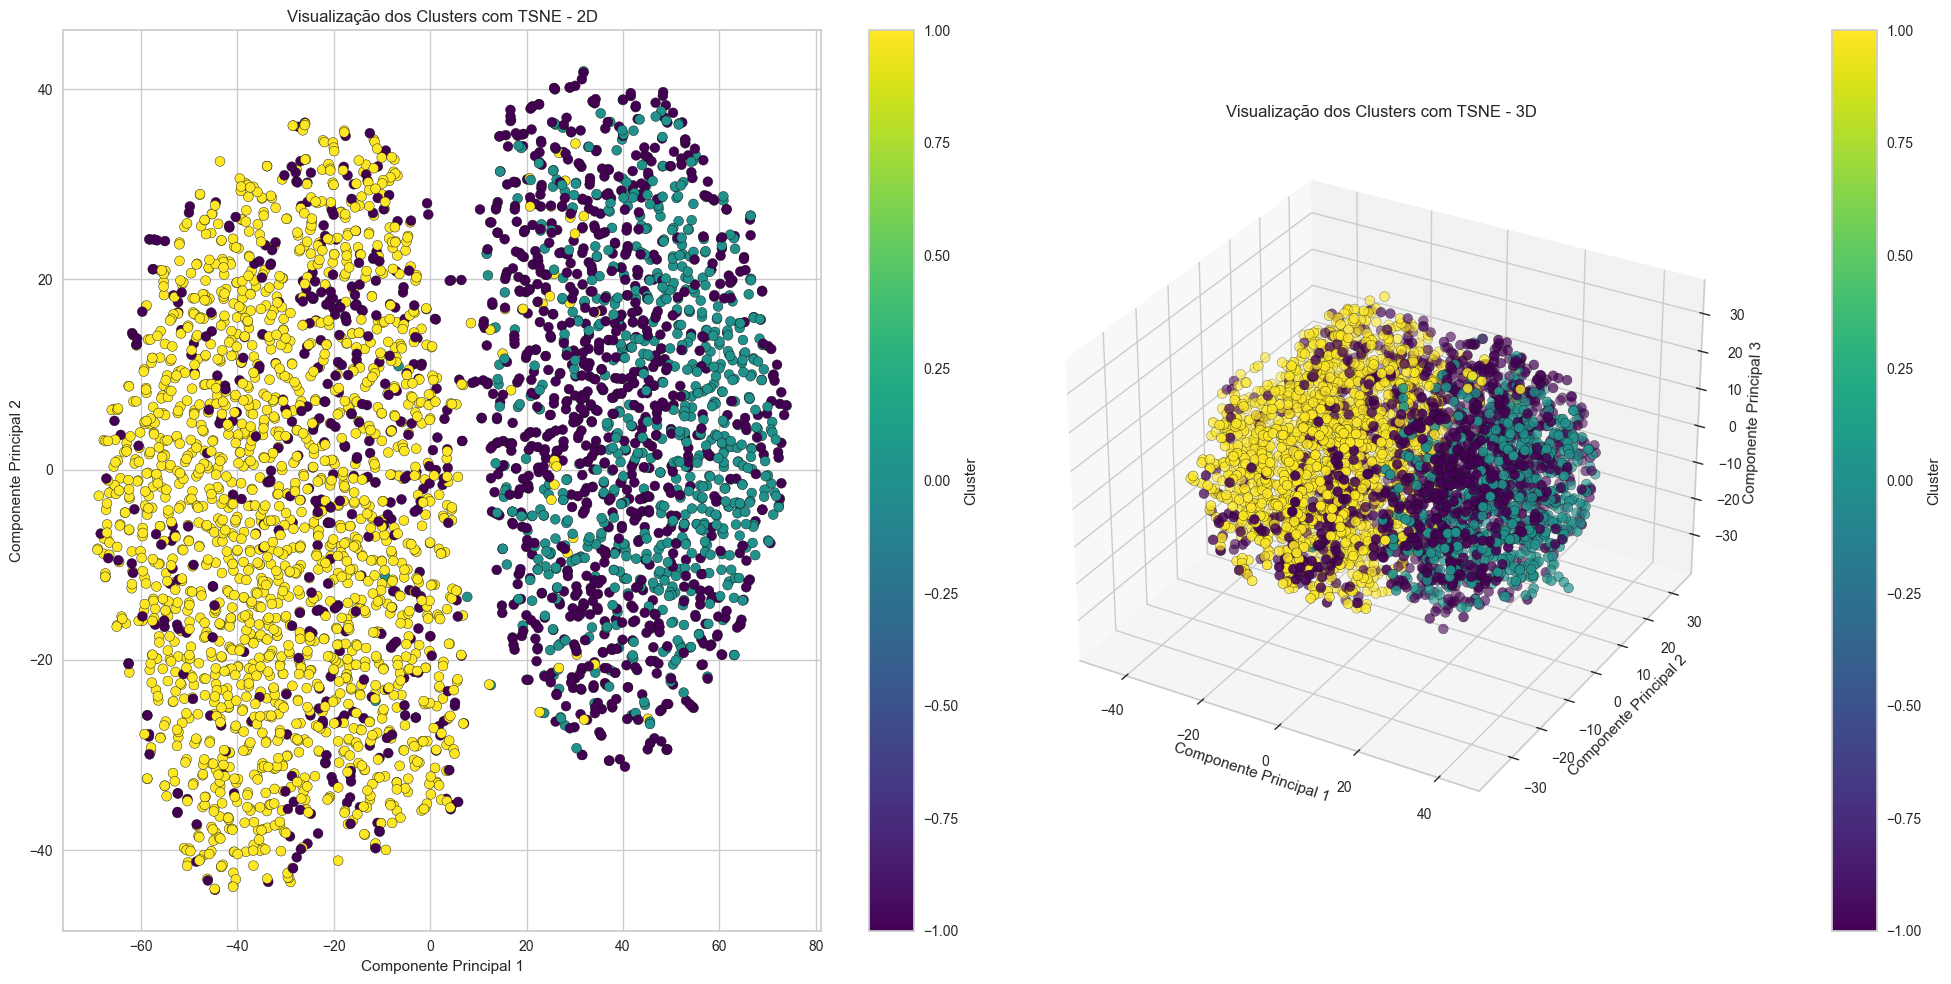

In [28]:
#TSNE
# Reduzir a dimensionalidade para 2 componentes principais
tsne = TSNE(n_components=2)
base_tsne = tsne.fit_transform(base)

# Reduzir a dimensionalidade para 3 componentes principais
tsne_3d = TSNE(n_components=3)
base_tsne_3d = tsne_3d.fit_transform(base)

# Criar uma figura com 2 subplots lado a lado
fig = plt.figure(figsize=(20, 10))

# Subplot 1: Gráfico 2D
ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(base_tsne[:, 0], base_tsne[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
ax1.set_title("Visualização dos Clusters com TSNE - 2D")
ax1.set_xlabel("Componente Principal 1")
ax1.set_ylabel("Componente Principal 2")
cbar1 = plt.colorbar(scatter_2d, ax=ax1)
cbar1.set_label('Cluster')

# Subplot 2: Gráfico 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(base_tsne_3d[:, 0], base_tsne_3d[:, 1], base_tsne_3d[:, 2], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
ax2.set_title("Visualização dos Clusters com TSNE - 3D")
ax2.set_xlabel("Componente Principal 1")
ax2.set_ylabel("Componente Principal 2")
ax2.set_zlabel("Componente Principal 3")

# Adicionar a barra de cores para o gráfico 3D
cbar2 = plt.colorbar(scatter_3d, ax=ax2, pad=0.1)
cbar2.set_label('Cluster')

plt.tight_layout()
plt.show()

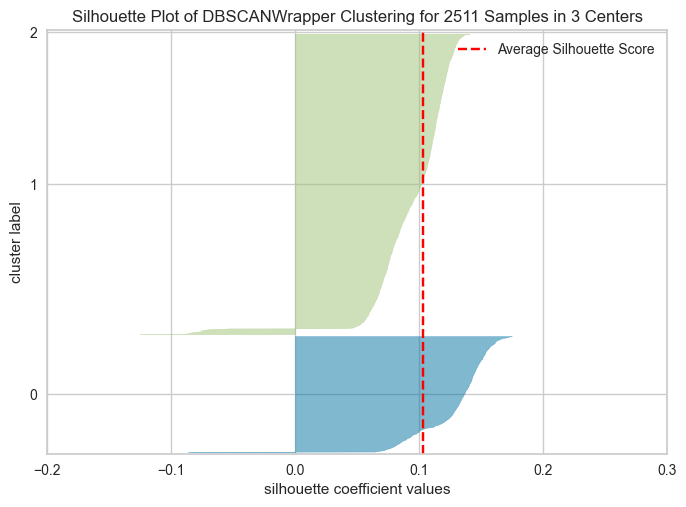

<Axes: title={'center': 'Silhouette Plot of DBSCANWrapper Clustering for 2511 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
class DBSCANWrapper(DBSCAN):
    n_clusters = (len(set(dbscan_labels)))
    def predict(self, data):
        return self.labels_.astype(int)

# Inicializando o wrapper DBSCAN com parâmetros específicos
clustersDB = DBSCANWrapper(eps=3.7894736842105265, min_samples=100)
wrapper_labels_db = clustersDB.fit_predict(base)

# Filtrando os pontos que não são ruído para visualização
non_noise_mask = wrapper_labels_db != -1
base_non_noise = base[non_noise_mask]
labels_non_noise = wrapper_labels_db[non_noise_mask]

# Visualizando com SilhouetteVisualizer, passando os labels diretamente
visualizer = SilhouetteVisualizer(DBSCANWrapper(eps=3.7894736842105265, min_samples=100), colors='yellowbrick')
visualizer.fit(base_non_noise, labels_non_noise)
visualizer.show()

### <span style='color:lightgreen'>  Avaliação dos Resultados </span>

In [41]:
# Avaliar K-Means
kmeans_silhouette = silhouette_score(base, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(base, kmeans_labels)
kmeans_calinski_harabasz = calinski_harabasz_score(base, kmeans_labels)

print("K-Means:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Score: {kmeans_davies_bouldin:.4f}")
print(f"Calinski and Harabasz Score: {kmeans_calinski_harabasz:.4f}")

# Avaliar DBSCAN
dbscan_silhouette = silhouette_score(base_non_noise, labels_non_noise)
dbscan_davies_bouldin = davies_bouldin_score(base_non_noise, labels_non_noise)
dbscan_calinski_harabasz = calinski_harabasz_score(base_non_noise, labels_non_noise)

print("\nDBSCAN:")
print(f"Silhouette Score: {dbscan_silhouette:.4f}")
print(f"Davies-Bouldin Score: {dbscan_davies_bouldin:.4f}")
print(f"Calinski and Harabasz Score: {dbscan_calinski_harabasz:.4f}")

# Avaliar Clusterização Hierárquica
hierarchical_silhouette = silhouette_score(base, hierarchical_labels)
hierarchical_davies_bouldin = davies_bouldin_score(base, hierarchical_labels)
hierarchical_calinski_harabasz = calinski_harabasz_score(base, hierarchical_labels)

print("\nClusterização Hierárquica:")
print(f"Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"Davies-Bouldin Score: {hierarchical_davies_bouldin:.4f}")
print(f"Calinski and Harabasz Score: {hierarchical_calinski_harabasz:.4f}")

# Criar dicionário para armazenar as pontuações
scores = {
    "K-Means": {
        "Silhouette Score": kmeans_silhouette,
        "Davies-Bouldin Score": kmeans_davies_bouldin,
        "Calinski and Harabasz Score": kmeans_calinski_harabasz
    },
    "DBSCAN": {
        "Silhouette Score": dbscan_silhouette,
        "Davies-Bouldin Score": dbscan_davies_bouldin,
        "Calinski and Harabasz Score": dbscan_calinski_harabasz
    },
    "Hierarchical": {
        "Silhouette Score": hierarchical_silhouette,
        "Davies-Bouldin Score": hierarchical_davies_bouldin,
        "Calinski and Harabasz Score": hierarchical_calinski_harabasz
    }
}

K-Means:
Silhouette Score: 0.0976
Davies-Bouldin Score: 2.9810
Calinski and Harabasz Score: 427.0328

DBSCAN:
Silhouette Score: 0.1036
Davies-Bouldin Score: 2.7467
Calinski and Harabasz Score: 261.0555

Clusterização Hierárquica:
Silhouette Score: 0.0966
Davies-Bouldin Score: 2.9982
Calinski and Harabasz Score: 421.9686


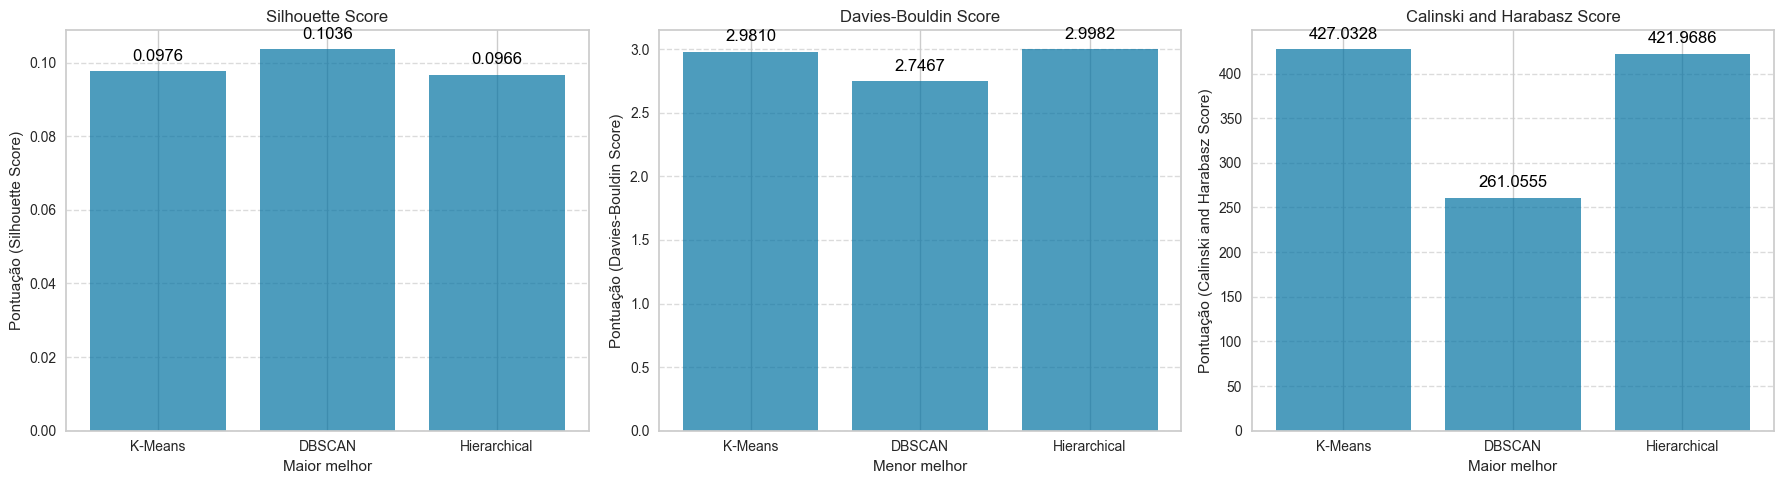

In [42]:
methods = list(scores.keys())
metrics = ["Silhouette Score", "Davies-Bouldin Score", "Calinski and Harabasz Score"]

# Inicializar os gráficos lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plotar cada métrica em um gráfico separado
for i, metric in enumerate(metrics):
    values = [scores[method][metric] for method in methods]
    axs[i].bar(methods, values, color='b', alpha=0.7)
    axs[i].set_ylabel(f'Pontuação ({metric})')
    axs[i].set_title(metric)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adicionar os valores em cima das barras
    for j, value in enumerate(values):
        axs[i].text(j, value + 0.02 * abs(max(values)), f'{value:.4f}', ha='center', va='bottom', color='black')

axs[0].set_xlabel('Maior melhor')
axs[1].set_xlabel('Menor melhor')
axs[2].set_xlabel('Maior melhor')

# Ajustar o layout
plt.tight_layout()
plt.show()

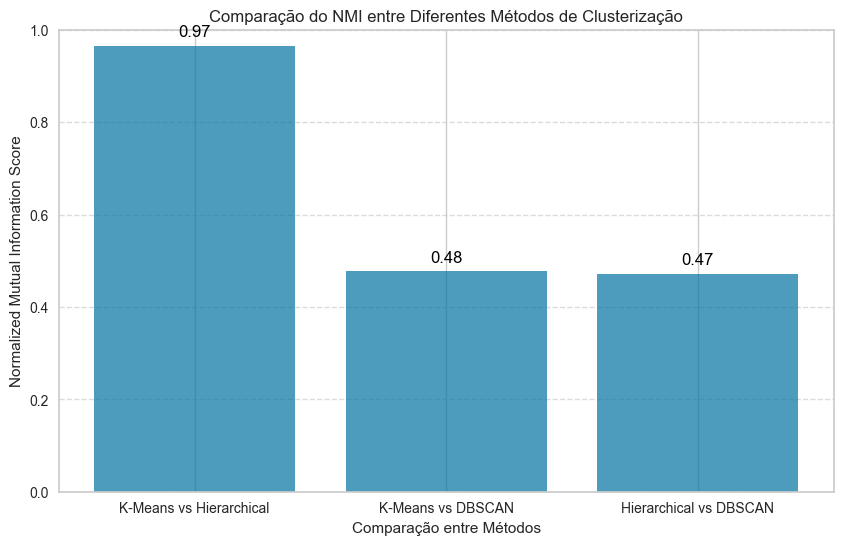

In [69]:
nmi_kmeans_hierarchical = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)
nmi_kmeans_dbscan = normalized_mutual_info_score(kmeans_labels, dbscan_labels)
nmi_hierarchical_dbscan = normalized_mutual_info_score(hierarchical_labels, dbscan_labels)

# Dados para o gráfico
methods_pairs = ['K-Means vs Hierarchical', 'K-Means vs DBSCAN', 'Hierarchical vs DBSCAN']
nmi_scores = [nmi_kmeans_hierarchical, nmi_kmeans_dbscan, nmi_hierarchical_dbscan]

# Gerar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(methods_pairs, nmi_scores, color='b', alpha=0.7)

# Adicionar os valores em cima das barras
for i, score in enumerate(nmi_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', color='black')

plt.xlabel('Comparação entre Métodos')
plt.ylabel('Normalized Mutual Information Score')
plt.title('Comparação do NMI entre Diferentes Métodos de Clusterização')
plt.ylim(0, 1)  # NMI varia entre 0 e 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
baseoriginal = pd.read_csv("shopping.csv")

In [64]:
non_noise_mask = wrapper_labels_db != -1
base_non_noise = baseoriginal[non_noise_mask]
labels_non_noise = wrapper_labels_db[non_noise_mask]

df = pd.DataFrame(base_non_noise)
df['Cluster'] = labels_non_noise

cluster_0_stats = df[df['Cluster'] == 0].mean()
cluster_1_stats = df[df['Cluster'] == 1].mean()
print("Médias das Features para o Cluster 0:")
print(cluster_0_stats)

print("\nMédias das Features para o Cluster 1:")
print(cluster_1_stats)

Médias das Features para o Cluster 0:
Customer ID              720.771429
Age                       42.302857
Purchase Amount (USD)     57.355714
Review Rating              3.635000
Previous Purchases        26.918571
Cluster                    0.000000
dtype: float64

Médias das Features para o Cluster 1:
Customer ID              2820.283269
Age                        44.040309
Purchase Amount (USD)      60.367753
Review Rating               3.738542
Previous Purchases         25.040309
Cluster                     1.000000
dtype: float64


C:\Users\ander\AppData\Local\Temp\ipykernel_19912\3892120649.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cluster_0_stats = df[df['Cluster'] == 0].mean()
C:\Users\ander\AppData\Local\Temp\ipykernel_19912\3892120649.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cluster_1_stats = df[df['Cluster'] == 1].mean()


In [68]:
df = pd.DataFrame(base_non_noise, columns=['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases'])
df['Cluster'] = labels_non_noise 

counts_feature1 = df.groupby('Cluster')['Frequency of Purchases'].value_counts()
print(counts_feature1)

counts_feature2 = df.groupby('Cluster')['Gender'].value_counts()
print(counts_feature2)

counts_feature3 = df.groupby('Cluster')['Location'].value_counts()
print(counts_feature3)

counts_feature4 = df.groupby('Cluster')['Size'].value_counts()
print(counts_feature4)

Cluster  Frequency of Purchases
0        Every 3 Months            135
         Fortnightly               125
         Monthly                   117
         Bi-Weekly                 104
         Annually                   97
         Quarterly                  70
         Weekly                     52
1        Every 3 Months            288
         Monthly                   277
         Bi-Weekly                 271
         Fortnightly               259
         Quarterly                 259
         Weekly                    237
         Annually                  220
Name: Frequency of Purchases, dtype: int64
Cluster  Gender
0        Male       700
1        Female    1088
         Male       723
Name: Gender, dtype: int64
Cluster  Location      
0        Delaware          25
         South Carolina    23
         California        21
         Minnesota         20
         Nevada            20
                           ..
1        Washington        29
         Michigan          28


### <span style='color:lightgreen'>  Análise dos Clusters </span> 

##### Cluster 0
- **Perfil de Compra:** Compra menos frequentemente
- **Gênero:** 100% homens

##### Cluster 1
- **Perfil de Compra:** Compra mais frequentemente
- **Gênero:** ~40% mulheres e ~60% homens